# ICC Cricket World Cup 2019 - Batting Impact
I have recently been thinking about cricket metrics, and the best way that we can measure how impactful a batsman is. This comes from recently seeing a fantastic thread on Twitter from [Dan Weston](https://twitter.com/SAAdvantage) about the PSL, as well as the recent discussions about where Moeen Ali should bat for England given his power hitting against spin, and where most of the spin overs are in a T20 match.  

I thought that I would apply these ideas and metrics to the top 50 run scorers from last year's ICC Cricket World Cup.  

I got these summary statistics from [ESPNCricInfo](http://stats.espncricinfo.com/ci/engine/records/batting/most_runs_career.html?id=12357;type=tournament). I have written a web scraper that pulls the data from that page and saves it as a csv so it is easier for me to import into Kaggle.  

All the details about the web scraper can be found in my [Cricketer Analysis repository](https://github.com/willcanniford/cricketer-analysis) on Github. 

In [1]:
# Imports for loading and cleaning data
import pandas as pd
import re
import numpy as np

# Imports for visualisations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Imports for batsman grouping and classification
from sklearn.cluster import KMeans
from sklearn import preprocessing 
from sklearn.metrics import silhouette_score, silhouette_samples

## Loading and preparing the data

In [2]:
world_cup_batting_raw = pd.read_csv("../input/world_cup_batting_raw.csv")
df = world_cup_batting_raw.loc[:, ['Player','Runs', 'BF','SR','4s','6s']].copy()
df.head(3)

,Player,Runs,BF,SR,4s,6s
0,RG Sharma (INDIA),648,659,98.33,67,14
1,DA Warner (AUS),647,724,89.36,66,8
2,Shakib Al Hasan (BDESH),606,631,96.03,60,2


### Clean `Player` column
In the raw form, straight from the website, the `Player` column contains the country in brackets after the player's name. I'd like to separate that out into its own column (`Country`) and remove that from `Player`. I'm going to write 2 simple regex functions that we can `apply` to the `pd.Series` to achieve this. 

In [3]:
def extract_country(player_string):
    regex = re.compile(r'.* \(([A-Z]*)\)')
    return(regex.search(player_string).group(1))

def clean_player_name(player_string):
    regex = re.compile(r'([a-zA-Z \-]*)\s\([A-Z]*\)')
    return(regex.search(player_string).group(1))

In [4]:
df['Country'] = df.Player.apply(extract_country) # Create separate `Country` column
df['Player'] = df.Player.apply(clean_player_name) # Clean and replace `Player`
df.head(3) # Inspect new format 

,Player,Runs,BF,SR,4s,6s,Country
0,RG Sharma,648,659,98.33,67,14,INDIA
1,DA Warner,647,724,89.36,66,8,AUS
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH


### Derive boundary-related metrics
The data as it currently stands just has the basic summary statistics for those individuals so I am going to derive some new ones that are based around the boundary hitting (using 4s and 6s), and work out the strike rate of the batsman if you remove the boundary balls from their stats.  

We will use some of these metrics later to classify the batsman into groups using `sklearn`. 

In [5]:
df['BoundaryRuns'] = df['4s'] * 4 + df['6s'] * 6
df['NonBoundaryRuns'] = df['Runs'] - df['BoundaryRuns']
df['TotalBoundaries'] = df['4s'] + df['6s']
df['NonBoundaryBalls'] = df['BF'] - df['TotalBoundaries']
df['RunsFromBoundary %'] = round(df['BoundaryRuns'] / df['Runs'] * 100, 2)
df['Boundary %'] = round(df['TotalBoundaries'] / df['BF'] * 100, 2)
df['NonBoundaryStrikeRate'] = round(df['NonBoundaryRuns'] / df['NonBoundaryBalls'] * 100, 2)
df['Boundary6 %'] = round(df['6s'] / (df['6s'] + df['4s']) * 100, 2)
df.head(3) # Inspect new format 

,Player,Runs,BF,SR,4s,6s,Country,BoundaryRuns,NonBoundaryRuns,TotalBoundaries,NonBoundaryBalls,RunsFromBoundary %,Boundary %,NonBoundaryStrikeRate,Boundary6 %
0,RG Sharma,648,659,98.33,67,14,INDIA,352,296,81,578,54.32,12.29,51.21,17.28
1,DA Warner,647,724,89.36,66,8,AUS,312,335,74,650,48.22,10.22,51.54,10.81
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH,252,354,62,569,41.58,9.83,62.21,3.23


## Visualising Batsman
Comparing the percentage of the balls that a batsman faced that were hit for boundaries, and the strike rate of the batsman in balls that weren't boundaries can give us a slight indication of how they approach the game.  

For example, Chris Gayle is known for his power hitting, and also his lack of running between the wickets. It therefore makes sense that his `NonBoundaryStrikeRate` is lowest of any batsman in this dataset.  

In this particular visualisation, you want to be aiming for the top right, as this indicates a lot of boundaries hit, as well as the ability to score off the balls that you don't connect with. Unfortunately this doesn't have context to the runs, as late over hitting yields both more aggressive batting, but also spread fields that allow for easy singles if you don't fully connect with the ball. 

In [6]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Country', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Boundary Impact'
)
fig.show()

Looking at both `Boundary %` and the `Boundary6 %` you can see the prolific 6 hitters, and the risk takers. Those that are scoring boundaries frequently, and big hits when they do go for it.  

Chris Gayle rises here, as his strong arms allow for more than average 6 hitting in the top half of the graph. Morgan sits at the very top of the graph, and his big hitting over the leg side is well known in international cricket; he was at it again in [South Africa](https://www.espncricinfo.com/series/19286/scorecard/1185315/south-africa-vs-england-3rd-t20i-england-in-sa-2019-20).

In [7]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='Boundary6 %', 
                 color='Country', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - 6 Hitting Impact'
)
fig.show()

## Scaling and classifying batsman data
Firstly, I need to decide which metrics that we have defined are going to help us to group the batsman into their groups. I don't think any of the summary statistics are appropriate here, as we are trying to define the style in which the batsman performs, rather than the amount of runs that they happened to score in this tournament.  

I have decided that I will work with just 3 groups in this example, which might not be the optimal grouping but I am working with only 50 players. 

In [8]:
grouping_columns = ['SR', 'RunsFromBoundary %', 'Boundary %', 'NonBoundaryStrikeRate', 'Boundary6 %']
df_chosen = df.loc[:,grouping_columns]

- `SR` - What is the general pace of the batsman's scoring? 
- `RunsFromBoundary %` - How reliant is the player on hitting boundaries for their runs? 
- `Boundary %` - How frequently do they find the rope? 
- `NonBoundaryStrikeRate` - Do they have other options and still able to score when not hitting boundaries?
- `Boundary6 %` - Do they take risks to gain maximum runs for a delivery? 

In [9]:
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df_chosen))
df_scaled.columns = grouping_columns
df_scaled.head(3)

,SR,RunsFromBoundary %,Boundary %,NonBoundaryStrikeRate,Boundary6 %
0,0.416037,0.612935,0.573925,-0.072033,0.249427
1,-0.132878,-0.015389,-0.065554,-0.037602,-0.359827
2,0.275290,-0.699335,-0.186036,1.075653,-1.073605


In [10]:
np.random.seed(1)

# Instantiate a model with 3 centers
kmeans = KMeans(3)

# Then fit the model to your data using the fit method
model = kmeans.fit(df_scaled)

# Finally predict the labels on the same data to show the category that point belongs to
labels = model.predict(df_scaled)

In [11]:
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
labels_group = pd.Series(labels, dtype="category").map({0:'A', 1:'B',2:'C'})
df['Batting Classification'] = labels_group

In [13]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Batting Classification', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Batting Classifications'
)
fig.show()

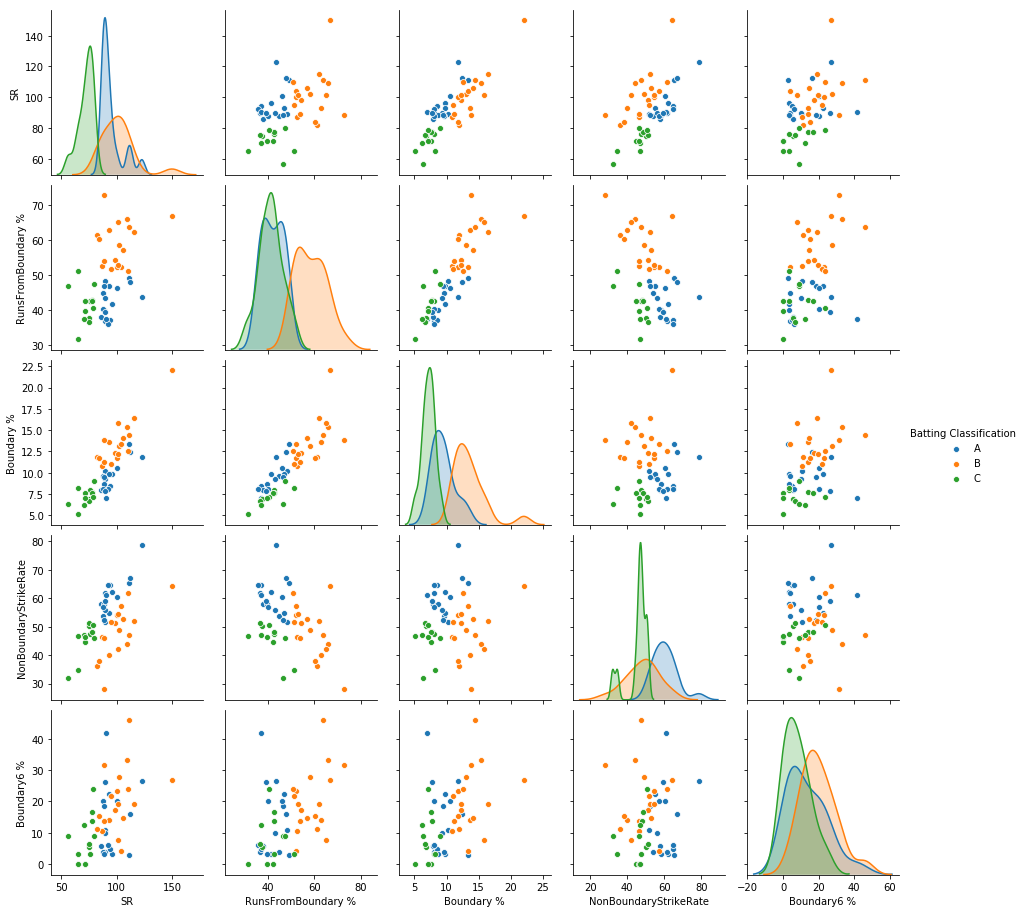

In [14]:
df_pair = df_chosen.copy()
df_pair['Batting Classification'] = labels_group
sns.pairplot(df_pair, hue='Batting Classification')
plt.show()

The fairly simply batting classification seems to have grouped them fairly sensibly (when looking at the visuals) when we use those 5 metrics but there are some plots where all the groups are muddied in the water, the `Boundary6 %` doesn't seem to separate out the batsman as well as the `Boundary %` for example. 

**Group A**  
DA Warner, Shakib Al Hasan, JE Root, Babar Azam, BA Stokes, V Kohli, F du Plessis, SPD Smith, Mushfiqur Rahim, UT Khawaja, JC Buttler, van der Dussen, MDKJ Perera, MS Dhoni, Mohammad Hafeez, HH Pandya, Mahmudullah, C de Grandhomme

**Group B**  
RG Sharma, JM Bairstow, AJ Finch, JJ Roy, AT Carey, EJG Morgan, N Pooran, Q de Kock, SO Hetmyer, CH Gayle, Zadran, WIA Fernando, Fakhar Zaman, MJ Guptill, Liton Das, GJ Maxwell, JO Holder, Soumya Sarkar

**Group C**  
KS Williamson, KL Rahul, LRPL Taylor, Imam-ul-Haq, SD Hope, Rahmat Shah, AD Mathews, Tamim Iqbal, JDS Neesham, FDM Karunaratne, HM Amla, Hashmatullah Shahidi, Gulbadin Naib

### Attempting to find a better `K` value
I'm not convinced of the value of `K` being 3. Let's use the Elbow Method and the Silhouette method to try and determine what the optimal value of `K` is.  

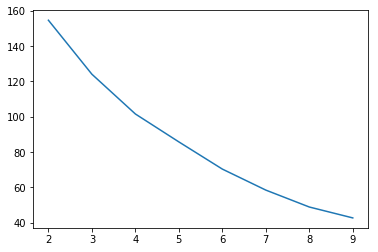

In [15]:
scores = []
clusters = [x for x in range(2,10)]
for i in clusters:
    kmeans = KMeans(i)
    model = kmeans.fit(df_scaled)
    scores.append(np.abs(model.score(df_scaled)))
    
plt.plot(clusters, scores)  
plt.show()

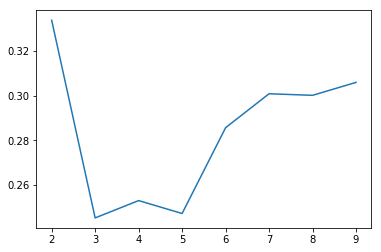

In [16]:
sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in clusters:
  kmeans = KMeans(n_clusters = k).fit(df_scaled)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))

plt.plot(clusters, sil)
plt.show()

The elbow method hasn't told us what the optimal level is, and the Silhouette method is just showing us that maybe more clusters would be better. I'm going to try with 8, but given the small sample size that we are clustering here, this may be too granular. 

In [17]:
kmeans = KMeans(8)
model = kmeans.fit(df_scaled)
labels = model.predict(df_scaled)
df_8_clusters = df.copy()
labels_group = pd.Series(labels, dtype="category").map({0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H'})
df_8_clusters['Batting Classification'] = labels_group
df_8_clusters['Batting Labels'] = labels
fig = px.scatter(df_8_clusters, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Batting Classification', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Batting Classifications'
)
fig.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.



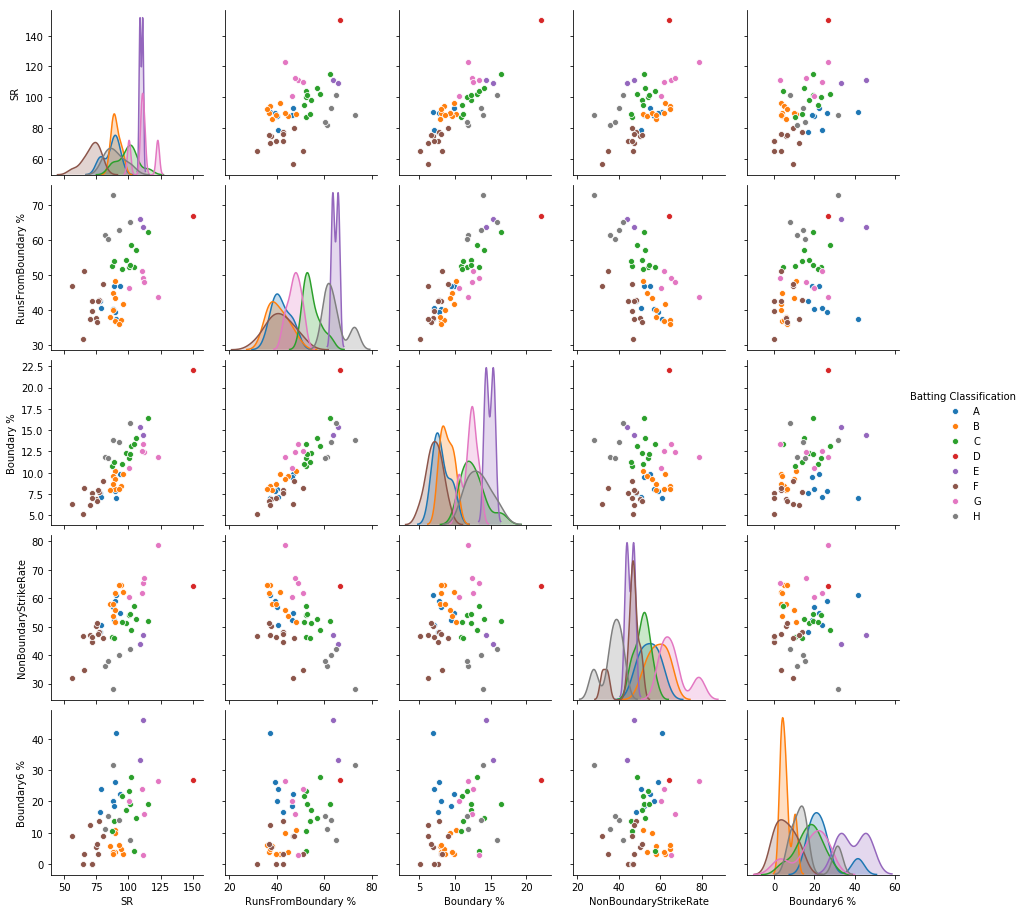

In [18]:
df_pair = df_chosen.copy()
df_pair['Batting Classification'] = labels_group
sns.pairplot(df_pair, hue='Batting Classification')
plt.show()

I suppose the most notable difference here is that this has completely isolated Maxwell.

- - -

I think when you get the point where you have that overlap with so many of the metrics that we are looking at then we have reached a point where K means clustering isn't necessarily the ideal method here. It really only benefits groups that are circular ultimately, and that doesn't immediately appear to be the case here. It is probably also worth considering removing some variables that don't seem to add any particular variation to the scores, as they are being judged equally thanks to our scaling. Taking a quick look at the variables (pre-scaling obviously) we can see that some variables aren't as varied as each other, and above is showing that we might be better performing a PCA analysis to group together variables that are correlated to get better clusters overall. 

In [19]:
df[grouping_columns].std() / df[grouping_columns].mean()

SR                       0.180345
RunsFromBoundary %       0.202751
Boundary %               0.313441
NonBoundaryStrikeRate    0.186546
Boundary6 %              0.733184
dtype: float64

- - -
### Outliers within clusters

We can explore this further by taking a look at the indiviual silhouette scores for each of the players and seeing where the overall values lies even though the average is good with the higher number of clusters. Using those scores we can take a further look at the players that aren't clearly in one cluster or the other. 

In [20]:
silhouette_scores = silhouette_samples(df_scaled, labels)
df.iloc[np.where(silhouette_scores < 0)]

,Player,Runs,BF,SR,4s,6s,Country,BoundaryRuns,NonBoundaryRuns,TotalBoundaries,NonBoundaryBalls,RunsFromBoundary %,Boundary %,NonBoundaryStrikeRate,Boundary6 %,Batting Classification
30,AD Mathews,244,314,77.70,20,4,SL,104,140,24,290,42.62,7.64,48.28,16.67,C
43,C de Grandhomme,190,189,100.52,16,4,NZ,88,102,20,169,46.32,10.58,60.36,20.00,A


Visualising these players might show us a bit more clearly why they could belong to multiple clusters under the current circumstances.

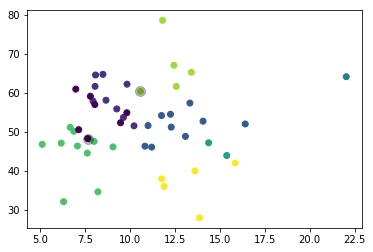

In [21]:
plt.scatter(df_8_clusters.loc[:, 'Boundary %'], 
            df_8_clusters.loc[:, 'NonBoundaryStrikeRate'], 
            c=df_8_clusters.loc[:, 'Batting Labels'])
cluster_outliers = np.where(silhouette_scores < 0)
cluster_outliers_index = df_8_clusters.index[cluster_outliers]
plt.scatter(df_8_clusters.loc[cluster_outliers_index, 'Boundary %'], 
            df_8_clusters.loc[cluster_outliers_index, 'NonBoundaryStrikeRate'], 
            c='black', 
            s=100, alpha=0.25)
plt.show()

While difficult to tell from a single graphic why these are excluded, we at least get a quick look at how those batsman could belong to more than a single cluster that we have identified. Another layer deeper into this investigation, we can take a look at the distances to the cluster centroids for these players and see if they are close to numerous other clusters. 

In [22]:
distances_to_clusters = model.transform(df_scaled)
pd.DataFrame(distances_to_clusters).join(
    pd.Series(silhouette_scores, name='SilhouetteScore')).join(
    pd.Series(labels, name='Group')).sort_values('SilhouetteScore').head(6)

,0,1,2,3,4,5,6,7,SilhouetteScore,Group
30,1.132676,1.754164,2.422745,7.010008,4.339939,1.172596,3.180909,3.190969,-0.033550,0
43,1.415181,1.677604,1.442881,5.162673,3.388361,2.993759,1.075713,3.295697,-0.025522,6
47,6.403448,6.420348,4.688604,0.000000,4.010209,7.684847,4.419579,5.476119,0.000000,3
31,4.636747,5.443942,3.454374,5.951237,2.544748,4.985116,5.183434,1.941351,0.022873,7
17,1.323704,1.626462,2.432606,7.044570,4.465545,0.944653,3.206727,3.175969,0.046772,5
1,1.602372,1.264390,1.329672,5.892347,3.780368,1.818854,2.255625,2.520071,0.053592,1


There is confusion for these values about which group they should be in. While the distances have assigned them to a particular group, the silhouette score indicates that they may be in the wrong group. It might be that they are more alike a different cluster that they are near and there was an issue with the initial random selection of the centroids at the beginning of the calculations. It may be assigned to cluster A, but might be nearer to all other points in cluster B, hence a negative silhouette score; an individual might be nearer to the centroid of its own cluster but nearer, on average, to the members of another cluster. 

- - -

I might well continue this, and try to improve the classification system through trying out other metric combinations and group sizes.  

If you've got any **suggestions** then please let me know, or any ideas or tips about how I can improve this kernel.  

If you've enjoyed reading this then please consider **upvoting** this kernel! 